In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import shap
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score, f1_score
from copy import deepcopy
from math import sqrt

In [2]:
derivation_cohort = pd.read_csv("Derivation_dataset.csv")
external_validation_cohort = pd.read_csv("External_validation_dataset.csv")

y = derivation_cohort['Outcome_Occlusion_MI']
X = derivation_cohort.drop('Outcome_Occlusion_MI', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 99)

y_val = external_validation_cohort['Outcome_Occlusion_MI']
X_val = external_validation_cohort.drop('Outcome_Occlusion_MI', axis=1)

for el in X_train.columns:
    X_train[el].fillna(X_train[el].mode()[0], inplace=True)
    X_test[el].fillna(X_train[el].mode()[0], inplace=True)
    X_val[el].fillna(X_train[el].mode()[0], inplace=True)

y_train = np.ravel(np.array(y_train.values))
y_test = np.ravel(np.array(y_test.values))
y_val = np.ravel(np.array(y_val.values))

columns = X_train.columns

X_train = np.array(X_train.values)
X_test = np.array(X_test.values)
X_val = np.array(X_val.values)

scaler = preprocessing.StandardScaler().fit(X_train) # Compute mean and std of training set
X_train = scaler.transform(X_train, copy=True)
X_test = scaler.transform(X_test, copy=True) # Standardize X_test using training mean and std
X_val = scaler.transform(X_val, copy=True)

C:\Users\arthu\AppData\Local\Temp\ipykernel_35272\3394752185.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[el].fillna(X_train[el].mode()[0], inplace=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_35272\3394752185.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [3]:
def plot_ROC_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=[5, 5])
    plt.title(title)
    plt.plot(fpr, tpr, color='b',
                 label=r'KNN (AUC = %0.3f)' % (roc_auc),
                 lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=.5)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate = 1 - Specificity')
    plt.ylabel('True Positive Rate = Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
def results(pred_probas):
    OMI_score = np.round(pred_probas[:, 1]*100, decimals=2)
    y_pred = np.where(OMI_score<5, 'Low risk', 'Intermediate risk')
    y_pred = np.where(OMI_score>=20, 'High risk', y_pred)
    
    results = {
        'Low risk': [np.count_nonzero(y_pred == 'Low risk')],
        'Intermediate risk': [np.count_nonzero(y_pred == 'Intermediate risk')],
        'High risk': [np.count_nonzero(y_pred == 'High risk')]
    }
    return(pd.DataFrame(data=results, index=['Count (N)']))

In [5]:
knn = KNeighborsClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}


In [14]:
# Proper hyperparameter tuning workflow using a validation set
print("Hyperparameter Tuning on Validation Set")

best_score = 0
best_params = {}
best_model = None

print("Searching for optimal hyperparameters...")
for n_neighbors in [3, 5, 7, 9, 11]:
    for weights in ['uniform', 'distance']:
        for metric in ['euclidean', 'manhattan']:
            # Create and train model with current parameters
            current_knn = KNeighborsClassifier(
                n_neighbors=n_neighbors,
                weights=weights,
                metric=metric
            )
            
            # Train on training set
            current_knn.fit(X_train, y_train)
            
            # Evaluate on validation set (using X_test as validation)
            val_probas = current_knn.predict_proba(X_test)
            current_auc = roc_auc_score(y_test, val_probas[:, 1])
            
            print(f"Parameters: n={n_neighbors}, weights={weights}, metric={metric}, AUC={current_auc:.4f}")
            
            # Track best model
            if current_auc > best_score:
                best_score = current_auc
                best_params = {
                    'n_neighbors': n_neighbors,
                    'weights': weights,
                    'metric': metric
                }
                best_model = current_knn

print(f"\nBest Parameters: {best_params}")
print(f"Best Validation AUC: {best_score:.4f}")

# Use the best model found
clf = best_model

# Get the best KNN model
clf = grid_search.best_estimator_
print(f"Best KNN parameters: {grid_search.best_params_}")



Hyperparameter Tuning on Validation Set
Searching for optimal hyperparameters...


NameError: name 'roc_auc_score' is not defined

Train
Best KNN parameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}


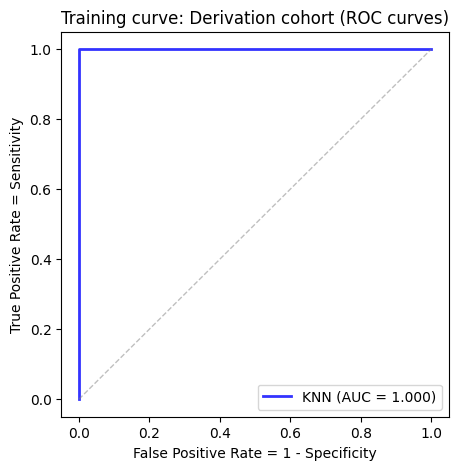

recall_clinical_score is:  1.0
f1 score is:  1.0


In [10]:
# Predict on training data
pred_probas_train = clf.predict_proba(X_train)
risk_groups_train = results(pred_probas_train)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_train, pred_probas_train[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Training curve: Derivation cohort (ROC curves)')

# Clinical threshold evaluation
y_pred_clinical = (pred_probas_train[:,1] >= 0.20).astype(int)
recall_clinical = recall_score(y_train, y_pred_clinical)
f1 = f1_score(y_train, y_pred_clinical)
print("recall_clinical_score is: ", recall_clinical)
print("f1 score is: ", f1)


Test


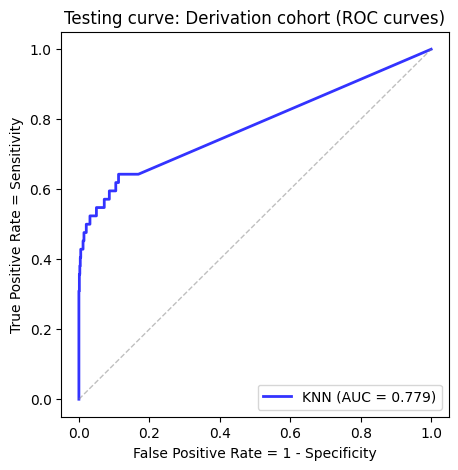

test recall_clinical_score is:  0.47619047619047616
test f1 score is:  0.547945205479452


In [11]:
# Evaluate on test set
print("\nTest")
pred_probas_test = clf.predict_proba(X_test)
risk_groups_test = results(pred_probas_test)

# Compute ROC curve and area under the curve for test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_probas_test[:,1])
roc_auc_test = auc(fpr_test, tpr_test)
plot_ROC_curve(fpr_test, tpr_test, roc_auc_test, 'Testing curve: Derivation cohort (ROC curves)')

# Clinical threshold evaluation on test set
y_pred_test_clinical = (pred_probas_test[:,1] >= 0.20).astype(int)
recall_test_clinical = recall_score(y_test, y_pred_test_clinical)
f1_test = f1_score(y_test, y_pred_test_clinical)
print("test recall_clinical_score is: ", recall_test_clinical)
print("test f1 score is: ", f1_test)


Validation


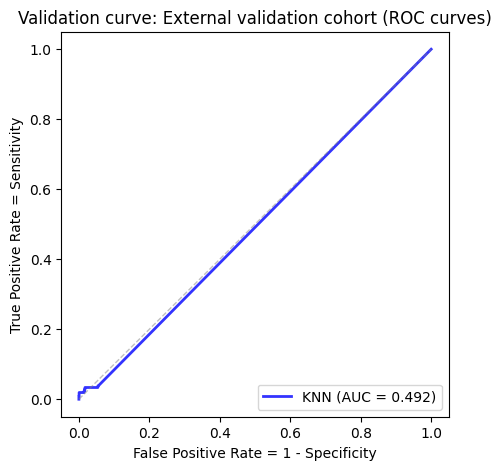

validation recall_clinical_score is:  0.014354066985645933
validation f1 score is:  0.028037383177570093


In [12]:
# Evaluate on validation set
print("\nValidation")
pred_probas_val = clf.predict_proba(X_val)
risk_groups_val = results(pred_probas_val)

# Compute ROC curve and area under the curve for validation set
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, pred_probas_val[:,1])
roc_auc_val = auc(fpr_val, tpr_val)
plot_ROC_curve(fpr_val, tpr_val, roc_auc_val, 'Validation curve: External validation cohort (ROC curves)')

# Clinical threshold evaluation on validation set
y_pred_val_clinical = (pred_probas_val[:,1] >= 0.20).astype(int)
recall_val_clinical = recall_score(y_val, y_pred_val_clinical)
f1_val = f1_score(y_val, y_pred_val_clinical)
print("validation recall_clinical_score is: ", recall_val_clinical)
print("validation f1 score is: ", f1_val)